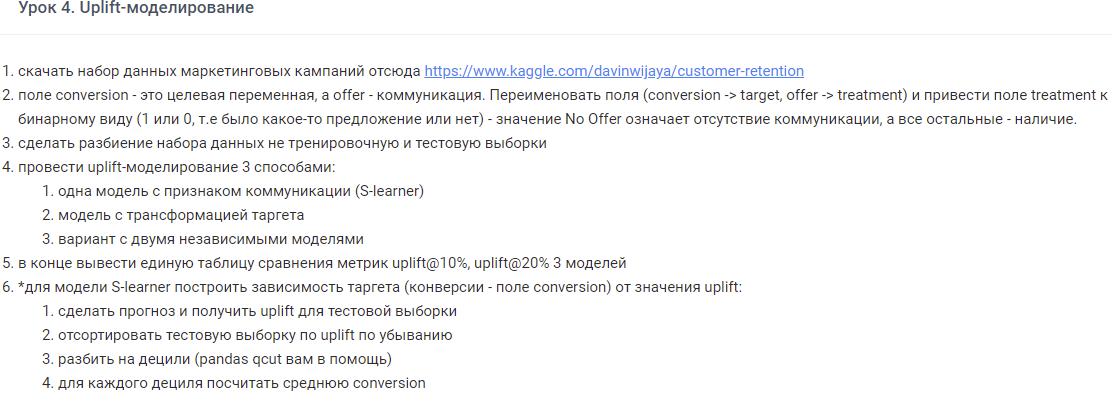

In [4]:
pip install scikit-uplift catboost

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')



### 1. Скачал данные

In [14]:
df = pd.read_csv('data.csv', sep=',')
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


### 2. Переименовал поля и привел поле `treatment` к бинарному виду

In [15]:
df.rename(columns={'conversion': "target", 'offer': 'treatment'}, inplace=True)
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [16]:
df.treatment.unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

In [17]:
df.loc[df.treatment == 'No Offer', 'treatment'] = 0
df.loc[df.treatment != 0, 'treatment'] = 1
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [18]:
df.channel.unique()

array(['Phone', 'Web', 'Multichannel'], dtype=object)

In [19]:
df.zip_code.unique()

array(['Surburban', 'Rural', 'Urban'], dtype=object)

In [20]:
# Отметим категорийные признаки
cat_features = ['channel', 'zip_code']

### 3. Разбил набор данных на тренировочную и тестовую выборки


In [25]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['target'], axis=1), df['target'], random_state=42, test_size=0.3)

 Для модели uplift нам надо три компонента X_train (признаки), y_train (целевое значение) и treat_train (признак взаимодействия). \
 Выдернем из X_train признак взаимодействия - treat_train


In [26]:
X_train.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment
9656,7,434.35,1,0,Urban,1,Web,0
63037,1,376.59,1,0,Surburban,0,Multichannel,1
31405,3,140.34,0,1,Urban,1,Phone,1
58088,3,150.76,0,1,Surburban,0,Web,0
44344,2,67.97,1,0,Surburban,1,Phone,1


In [27]:
# Выдернем из X_train признак взаимодействия - treat_train
treat_train = X_train.treatment

# Удалим из X_train признак взаимодействия
X_train.drop(['treatment'], axis=1, inplace=True)
X_train.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
9656,7,434.35,1,0,Urban,1,Web
63037,1,376.59,1,0,Surburban,0,Multichannel
31405,3,140.34,0,1,Urban,1,Phone
58088,3,150.76,0,1,Surburban,0,Web
44344,2,67.97,1,0,Surburban,1,Phone


In [28]:
# То же самое для теста
treat_valid = X_test.treatment

X_test.drop(['treatment'], axis=1, inplace=True)
X_test.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
33042,9,64.85,1,0,Surburban,1,Web
7209,1,144.12,0,1,Urban,0,Web
24367,1,734.25,0,1,Surburban,1,Phone
19599,4,1321.26,1,0,Surburban,1,Multichannel
31465,2,261.23,1,1,Surburban,1,Web


In [29]:
#  Создадим таблицу для сбора результатов
metrics_df = pd.DataFrame(columns=['model', 'uplift@10%', 'uplift@20%', 'uplift@30%'])

### 4.1 Одна модель с признаком коммуникации (S-learner)

In [30]:

sm = SoloModel(CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features))

sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_valid, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_valid, strategy='by_group', k=0.2)
sm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_valid, strategy='by_group', k=0.3)

metrics_df = metrics_df.append({
    'model': type(sm).__name__,
    'uplift@10%': sm_score_10,
    'uplift@20%': sm_score_20,
    'uplift@30%': sm_score_30,
}, ignore_index=True)

metrics_df

,model,uplift@10%,uplift@20%,uplift@30%
0,SoloModel,0.122913,0.100633,0.09265


### 4.2 Модель с трансформацией таргета

In [32]:
from sklift.models import ClassTransformation

ct = ClassTransformation(CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features))

ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_valid, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_valid, strategy='by_group', k=0.2)
ct_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_valid, strategy='by_group', k=0.3)


metrics_df = metrics_df.append({
    'model': type(ct).__name__,
    'uplift@10%': ct_score_10,
    'uplift@20%': ct_score_20,
    'uplift@30%': ct_score_30,
}, ignore_index=True)

metrics_df

,model,uplift@10%,uplift@20%,uplift@30%
0,SoloModel,0.122913,0.100633,0.092650
1,ClassTransformation,0.119108,0.103868,0.087555


### 4.3 Вариант с двумя независимыми моделями

In [33]:
from sklift.models import TwoModels


tm = TwoModels(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features),
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features),
    method='vanilla'  # независимые модели
)
tm = tm.fit(
    X_train, y_train, treat_train
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_valid, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_valid, strategy='by_group', k=0.2)
tm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_valid, strategy='by_group', k=0.3)


metrics_df = metrics_df.append({
    'model': type(tm).__name__,
    'uplift@10%': tm_score_10,
    'uplift@20%': tm_score_20,
    'uplift@30%': tm_score_30,
}, ignore_index=True)

metrics_df

,model,uplift@10%,uplift@20%,uplift@30%
0,SoloModel,0.122913,0.100633,0.092650
1,ClassTransformation,0.119108,0.103868,0.087555
2,TwoModels,0.109515,0.091545,0.078819
